In [1]:
import sys
import os
import time
sys.path.append(os.path.abspath('../..'))

import gpflow
import tensorflow as tf
from gpflow.optimizers import Scipy

from rcgp.morcgp import MOGPRegressor_NC, MORCGP_shared_noise
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 28,         
    'axes.labelsize': 28,    
    'axes.titlesize': 30,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 24,
    'lines.linewidth': 5,    
    'lines.markersize': 6   
})

c:\Users\joshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    return np.mean(nlpd_values)

In [3]:
def uniform_outliers_c1(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")

    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N 
    num_outliers = int(np.round(percent_outliers * total_elements))

    row_indices = np.random.choice(N, num_outliers, replace=False)

    signs = np.random.choice([-1, 1], size=num_outliers)

    uniform_values = np.random.uniform(start, end, size=num_outliers) * signs

    Y_outliers[row_indices, 0] += uniform_values

    return Y_outliers

def asymmetric_outliers_c1(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")
    
    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N 
    num_outliers = int(np.round(percent_outliers * total_elements))

    row_indices = np.random.choice(N, num_outliers, replace=False)

    uniform_values = np.random.uniform(start, end, size=num_outliers)

    Y_outliers[row_indices, 0] += uniform_values

    return Y_outliers

def focused_outliers_c1(X, Y, percent_outliers, y_value, perturbation=0.1):
    def mad(X):
        medians = np.median(X, axis=0)
        deviations = np.abs(X - medians)
        return np.median(deviations, axis=0)

    X = X.copy()
    Y = Y.copy()

    n_samples, n_features = X.shape
    n_outliers = int(n_samples * percent_outliers)

    # Indices of outliers
    indices = np.random.choice(n_samples, size=n_outliers, replace=False)

    medians_2d = np.tile(np.median(X, axis=0), (n_outliers, 1))

    def mad(X, axis=0):
        """Compute Median Absolute Deviation (MAD)"""
        med = np.median(X, axis=axis)
        return np.median(np.abs(X - med), axis=axis)

    mads = mad(X)
    mads_2d = np.tile(mads, (n_outliers, 1))

    u = np.random.uniform(0, perturbation, size=medians_2d.shape)
    X_outliers = medians_2d + u * mads_2d

    Y_outliers = np.full(shape=n_outliers, fill_value=y_value)

    first_column = Y[:, 0]
    median_y0 = np.median(first_column)
    mad_y0 = np.median(np.abs(first_column - median_y0))
    Y_mad_outliers = np.full(shape=n_outliers, fill_value=mad_y0)

    # Draw u independently for each element
    u = np.random.uniform(0, perturbation, size=Y_outliers.shape)

    # Compute the perturbed Y_outliers
    Y_outliers_perturbed = Y_outliers + u * Y_mad_outliers

    X[indices, :] = X_outliers
    Y[indices, 0] = Y_outliers_perturbed

    return X, Y

In [ ]:
def make_X_multi(X, D=2):
    """
    X: shape (N, input_dim) - multi-dimensional input
    D: number of tasks
    """
    N, input_dim = X.shape
    X_multi = []
    
    for task in range(D):
        # Add task index as last column
        X_task = np.hstack([X, np.full((N, 1), task)])
        X_multi.append(X_task)
    
    return np.vstack(X_multi)  # Shape: (N*D, input_dim + 1)

def run_MOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled):

    start_total = time.time()

    X_multi_train = make_X_multi(X_train_scaled, D=2)
    X_multi_test = make_X_multi(X_test_scaled, D=2)
    Y_multi_train = Y_train_scaled.reshape(-1, 1, order='F')
    Y_multi_test = Y_test_scaled.reshape(-1, 1, order='F')

    input_dim = X_train_scaled.shape[1]  # number of features
    D = 2  # number of tasks

    base_kernel = gpflow.kernels.RBF(
        lengthscales=1.0,
        variance=0.1,
        active_dims=list(range(input_dim))
    )

    coregion_kernel = gpflow.kernels.Coregion(
        output_dim=D,
        rank=D,
        active_dims=[input_dim]
    )

    gpflow.utilities.set_trainable(coregion_kernel.kappa, False)
    coregion_kernel.kappa.assign(tf.ones_like(coregion_kernel.kappa) * 1e-6)

    kernel = base_kernel * coregion_kernel

    model_gpr = gpflow.models.GPR(
        data=(X_multi_train, Y_multi_train),
        kernel=kernel,
        mean_function=None
    )

    gpflow.utilities.set_trainable(base_kernel.variance, False)

    opt = Scipy()

    def objective_closure_gpr():
        return -model_gpr.log_marginal_likelihood()
    try:
        opt.minimize(objective_closure_gpr, model_gpr.trainable_variables, options=dict(maxiter=1000))
    except Exception as e:
        print(f"Optimization failed: {e}")
        print("Try reducing maxiter or checking data shapes")

    mean_pred_mogp, var_pred_mogp = model_gpr.predict_y(X_multi_test)
    mu_mogp, std_mogp = mean_pred_mogp.numpy().reshape(-1, D, order='F'), np.sqrt(var_pred_mogp.numpy()).reshape(-1, D, order='F')

    end_total = time.time()
    time_mogp = end_total - start_total

    rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp.reshape(-1, D, order='F'))
    nlpd_mogp = nlpd(Y_test_scaled, mu_mogp.reshape(-1, D, order='F'), std_mogp.reshape(-1, D, order='F')**2)
    
    return rmse_mogp, nlpd_mogp, time_mogp


def run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers, k=1):
    start_total = time.time()

    mcd = MinCovDet(support_fraction=1-prop_outliers).fit(Y_train_scaled)
    robust_covariance = mcd.covariance_
    robust_init_A = np.linalg.cholesky(robust_covariance)

    morcgp = MORCGP_shared_noise(mean=0, length_scale=1, noise_var=0.1, A=robust_init_A)
    morcgp.fit(X_train_scaled, Y_train_scaled, epsilons=np.array([prop_outliers, 0]))
    morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=k, init_cov=robust_covariance, fix_weights=True)

    mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
    std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)
    end_total = time.time()

    time_morcgp = end_total - start_total
    rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)
    nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

    return rmse_morcgp, nlpd_morcgp, time_morcgp

def run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df):

    X_multi_train = make_X_multi(X_train_scaled, D=2)
    X_multi_test = make_X_multi(X_test_scaled, D=2)
    Y_multi_train = Y_train_scaled.reshape(-1, 1, order='F')
    Y_multi_test = Y_test_scaled.reshape(-1, 1, order='F')

    input_dim = X_train_scaled.shape[1]  
    N = X_train_scaled.shape[0]
    D = 2

    start_total = time.time()

    base_kernel = gpflow.kernels.RBF(
        lengthscales=1.0, 
        variance=0.1, 
        active_dims=list(range(input_dim)) ,
    )

    coregion_kernel = gpflow.kernels.Coregion(
        output_dim=D, 
        rank=D, 
        active_dims=[input_dim]  
    )

    gpflow.utilities.set_trainable(base_kernel.variance, False)

    gpflow.utilities.set_trainable(coregion_kernel.kappa, False)
    coregion_kernel.kappa.assign(tf.ones_like(coregion_kernel.kappa) * 1e-6)

    kernel = base_kernel * coregion_kernel

    likelihood_vgp = gpflow.likelihoods.StudentT(df=df)
    model_vgp = gpflow.models.VGP(
        data=(X_multi_train, Y_multi_train),
        kernel=kernel,
        likelihood=likelihood_vgp
    )

    opt = Scipy()
    def objective_closure_vgp():
        return -model_vgp.maximum_log_likelihood_objective()

    try:
        opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))
    except Exception as e:
        print(f"Optimization failed: {e}")
        print("Try reducing maxiter or checking data shapes")

    mean_pred_tmogp, var_pred_tmogp = model_vgp.predict_y(X_multi_test)
    mu_tmogp, std_tmogp = mean_pred_tmogp.numpy().reshape(-1, D, order='F'), np.sqrt(var_pred_tmogp.numpy()).reshape(-1, D, order='F')
    end_total = time.time()

    time_tmogp = end_total - start_total
    rmse_tmogp = calculate_rmse(Y_test_scaled, mu_tmogp.reshape(-1, D, order='F'))
    nlpd_tmogp = nlpd(Y_test_scaled, mu_tmogp.reshape(-1, D, order='F'), std_tmogp.reshape(-1, D, order='F')**2)
    
    return rmse_tmogp, nlpd_tmogp, time_tmogp

def run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers):

    start_total = time.time()

    mcd = MinCovDet(support_fraction=1-prop_outliers).fit(Y_train_scaled)
    robust_covariance = mcd.covariance_
    robust_init_A = np.linalg.cholesky(robust_covariance)

    mogp = MOGPRegressor_NC(mean = 0, length_scale=1, noise = 0.1, A=robust_init_A)
    mogp.fit(X_train_scaled, Y_train_scaled)
    mogp.optimize_hyperparameters()

    mu_mogp, var_mogp = mogp.predict(X_test_scaled)
    std_mogp = np.sqrt(var_mogp + mogp.noise)
    end_total = time.time()

    time_mogp = end_total - start_total
    rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
    nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)

    return rmse_mogp, nlpd_mogp, time_mogp


In [ ]:
# Import dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
df = pd.read_excel(url)
X = df.loc[:, 'X1':'X8'].to_numpy()
Y = df.loc[:, ['Y1', 'Y2']].to_numpy()

# No outliers

In [ ]:
rmses_mogp, rmses_morcgp, rmses_tmogp = [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_tmogp = [], [], []
times_mogp, times_morcgp, times_tmogp = [], [], []

prop_outliers = 0
num_seeds = 20

run_mogp = False
run_morcgp = True
run_tmogp = False

for i in tqdm(range(num_seeds)):

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=i
    )

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    if run_mogp:
        rmse_mogp, nlpd_mogp, time_mogp = run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers)
        print(f'No outliers: MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}, Time = {time_mogp}')
        rmses_mogp.append(rmse_mogp)
        nlpds_mogp.append(nlpd_mogp)
        times_mogp.append(time_mogp)
    if run_morcgp:
        rmse_morcgp, nlpd_morcgp, time_morcgp = run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers, k=2)
        print(f'No outliers: MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}, Time = {time_morcgp}')
        rmses_morcgp.append(rmse_morcgp)
        nlpds_morcgp.append(nlpd_morcgp)
        times_morcgp.append(time_morcgp)
    if run_tmogp:
        rmse_tmogp, nlpd_tmogp, time_tmogp = run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df=10)
        print(f'No outliers: t-MOGP seed {i}: RMSE = {rmse_tmogp}, NLPD = {nlpd_tmogp}, Time = {time_tmogp}')
        rmses_tmogp.append(rmse_tmogp)
        nlpds_tmogp.append(nlpd_tmogp)
        times_tmogp.append(time_tmogp)

if run_mogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_mogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_mogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_mogp))
    print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
    print(f'Time MOGP: {np.mean(times_mogp):.4f} ± {np.std(times_mogp):.4f}')

if run_morcgp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_morcgp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_morcgp))
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
    print(f'Time MORCGP: {np.mean(times_morcgp):.4f} ± {np.std(times_morcgp):.4f}')

if run_tmogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_tmogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_tmogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_tmogp))
    print(f'RMSE t-MOGP: {np.mean(rmses_tmogp):.4f} ± {np.std(rmses_tmogp):.4f}')
    print(f'NLPD t-MOGP: {np.mean(nlpds_tmogp):.4f} ± {np.std(nlpds_tmogp):.4f}')
    print(f'Time t-MOGP: {np.mean(times_tmogp):.4f} ± {np.std(times_tmogp):.4f}')

  5%|▌         | 1/20 [01:17<24:38, 77.83s/it]

No outliers: MORCGP seed 0: RMSE = 0.12511164877270067, NLPD = -0.8502006690386331, Time = 77.82242465019226


 10%|█         | 2/20 [02:01<17:15, 57.52s/it]

No outliers: MORCGP seed 1: RMSE = 0.11565353556189453, NLPD = -0.7951018873299732, Time = 43.29043102264404


 15%|█▌        | 3/20 [02:20<11:20, 40.01s/it]

No outliers: MORCGP seed 2: RMSE = 0.11263040684725086, NLPD = -0.8936218871221687, Time = 19.172266244888306


 20%|██        | 4/20 [02:47<09:20, 35.04s/it]

No outliers: MORCGP seed 3: RMSE = 0.10322468166714477, NLPD = -0.9852527013899718, Time = 27.397711277008057


 25%|██▌       | 5/20 [03:42<10:32, 42.17s/it]

No outliers: MORCGP seed 4: RMSE = 0.1036289847066638, NLPD = -0.9544113567325532, Time = 54.78970718383789


 30%|███       | 6/20 [04:28<10:06, 43.29s/it]

No outliers: MORCGP seed 5: RMSE = 0.1110687032642824, NLPD = -0.804737913042859, Time = 45.480496883392334


 35%|███▌      | 7/20 [05:04<08:52, 40.99s/it]

No outliers: MORCGP seed 6: RMSE = 0.1263126202858803, NLPD = -0.6758904211837723, Time = 36.2379732131958


 40%|████      | 8/20 [05:23<06:48, 34.03s/it]

No outliers: MORCGP seed 7: RMSE = 0.1250473655624421, NLPD = -0.8139530414179529, Time = 19.106127738952637


 45%|████▌     | 9/20 [06:01<06:26, 35.16s/it]

No outliers: MORCGP seed 8: RMSE = 0.10869172425354147, NLPD = -0.9313949809316182, Time = 37.63733959197998


 50%|█████     | 10/20 [06:29<05:30, 33.07s/it]

No outliers: MORCGP seed 9: RMSE = 0.11864261714692591, NLPD = -0.9292778123781451, Time = 28.398036003112793


 55%|█████▌    | 11/20 [07:22<05:51, 39.08s/it]

No outliers: MORCGP seed 10: RMSE = 0.09719616937802693, NLPD = -0.9667321624757278, Time = 52.69677138328552


 60%|██████    | 12/20 [08:08<05:30, 41.33s/it]

No outliers: MORCGP seed 11: RMSE = 0.13743244242628158, NLPD = -0.6210425438031559, Time = 46.46093702316284


 65%|██████▌   | 13/20 [08:44<04:37, 39.65s/it]

No outliers: MORCGP seed 12: RMSE = 0.12936333970669145, NLPD = -0.7628453793248248, Time = 35.772677183151245


 70%|███████   | 14/20 [09:31<04:11, 41.87s/it]

No outliers: MORCGP seed 13: RMSE = 0.1362922114651111, NLPD = -0.7316155823305087, Time = 46.99382734298706


 75%|███████▌  | 15/20 [10:51<04:27, 53.51s/it]

No outliers: MORCGP seed 14: RMSE = 0.090274868135089, NLPD = -1.0521651410433168, Time = 80.47853207588196


 80%|████████  | 16/20 [11:42<03:30, 52.61s/it]

No outliers: MORCGP seed 15: RMSE = 0.12410908560503306, NLPD = -0.8727773167402573, Time = 50.50668001174927


 85%|████████▌ | 17/20 [13:08<03:08, 62.80s/it]

No outliers: MORCGP seed 16: RMSE = 0.10082132232392665, NLPD = -0.9254462477750997, Time = 86.4893159866333


 90%|█████████ | 18/20 [13:45<01:49, 54.80s/it]

No outliers: MORCGP seed 17: RMSE = 0.10469056003379244, NLPD = -0.9846299217657357, Time = 36.16512179374695


 95%|█████████▌| 19/20 [14:03<00:44, 44.02s/it]

No outliers: MORCGP seed 18: RMSE = 0.1478571780966549, NLPD = -0.8211240999200956, Time = 18.880886554718018


100%|██████████| 20/20 [14:36<00:00, 43.81s/it]

No outliers: MORCGP seed 19: RMSE = 0.13276842555572813, NLPD = -0.7758588112911132, Time = 32.24533820152283
RMSE: 0.1251, 0.1157, 0.1126, 0.1032, 0.1036, 0.1111, 0.1263, 0.1250, 0.1087, 0.1186, 0.0972, 0.1374, 0.1294, 0.1363, 0.0903, 0.1241, 0.1008, 0.1047, 0.1479, 0.1328
NLPD: -0.8502, -0.7951, -0.8936, -0.9853, -0.9544, -0.8047, -0.6759, -0.8140, -0.9314, -0.9293, -0.9667, -0.6210, -0.7628, -0.7316, -1.0522, -0.8728, -0.9254, -0.9846, -0.8211, -0.7759
Time: 77.8224, 43.2904, 19.1723, 27.3977, 54.7897, 45.4805, 36.2380, 19.1061, 37.6373, 28.3980, 52.6968, 46.4609, 35.7727, 46.9938, 80.4785, 50.5067, 86.4893, 36.1651, 18.8809, 32.2453
RMSE MORCGP: 0.1175 ± 0.0149
NLPD MORCGP: -0.8574 ± 0.1093
Time MORCGP: 43.8011 ± 19.0859


# Uniform outliers

In [ ]:
rmses_mogp, rmses_morcgp, rmses_tmogp = [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_tmogp = [], [], []
times_mogp, times_morcgp, times_tmogp = [], [], []

prop_outliers = 0.1
num_seeds = 20

run_mogp = True
run_morcgp = True
run_tmogp = True

for i in tqdm(range(num_seeds)):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=i
    )

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    Y_train_scaled = uniform_outliers_c1(Y=Y_train_scaled, percent_outliers=prop_outliers, start=6, end=9)

    if run_mogp:
        rmse_mogp, nlpd_mogp, time_mogp = run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers)
        print(f'Uniform outliers: MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}, Time = {time_mogp}')
        rmses_mogp.append(rmse_mogp)
        nlpds_mogp.append(nlpd_mogp)
        times_mogp.append(time_mogp)
    if run_morcgp:
        rmse_morcgp, nlpd_morcgp, time_morcgp = run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers, k=2)
        print(f'Uniform outliers: MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}, Time = {time_morcgp}')
        rmses_morcgp.append(rmse_morcgp)
        nlpds_morcgp.append(nlpd_morcgp)
        times_morcgp.append(time_morcgp)
    if run_tmogp:
        rmse_tmogp, nlpd_tmogp, time_tmogp = run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df=10)
        print(f'Uniform outliers: t-MOGP seed {i}: RMSE = {rmse_tmogp}, NLPD = {nlpd_tmogp}, Time = {time_tmogp}')
        rmses_tmogp.append(rmse_tmogp)
        nlpds_tmogp.append(nlpd_tmogp)
        times_tmogp.append(time_tmogp)

if run_mogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_mogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_mogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_mogp))
    print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
    print(f'Time MOGP: {np.mean(times_mogp):.4f} ± {np.std(times_mogp):.4f}')

if run_morcgp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("Time:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
    print(f'Time MORCGP: {np.mean(times_morcgp):.4f} ± {np.std(times_morcgp):.4f}')

if run_tmogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_tmogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_tmogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_tmogp))
    print(f'RMSE t-MOGP: {np.mean(rmses_tmogp):.4f} ± {np.std(rmses_tmogp):.4f}')
    print(f'NLPD t-MOGP: {np.mean(nlpds_tmogp):.4f} ± {np.std(nlpds_tmogp):.4f}')
    print(f'Time t-MOGP: {np.mean(times_tmogp):.4f} ± {np.std(times_tmogp):.4f}')

  5%|▌         | 1/20 [00:32<10:23, 32.81s/it]

Uniform outliers: MOGP seed 0: RMSE = 1.5542110849362754, NLPD = 1.4419766746527696, Time = 32.803264141082764


 10%|█         | 2/20 [01:08<10:21, 34.55s/it]

Uniform outliers: MOGP seed 1: RMSE = 1.527532008372313, NLPD = 1.4763475681744307, Time = 35.76046180725098


 15%|█▌        | 3/20 [01:39<09:19, 32.91s/it]

Uniform outliers: MOGP seed 2: RMSE = 1.031426555553717, NLPD = 1.3809989077199676, Time = 30.952619075775146


 20%|██        | 4/20 [02:13<08:56, 33.52s/it]

Uniform outliers: MOGP seed 3: RMSE = 1.1713495013726996, NLPD = 1.3692690349380847, Time = 34.43743395805359


 25%|██▌       | 5/20 [02:48<08:28, 33.87s/it]

Uniform outliers: MOGP seed 4: RMSE = 1.523293928620285, NLPD = 1.4466994646599896, Time = 34.48757481575012


 30%|███       | 6/20 [03:22<07:56, 34.04s/it]

Uniform outliers: MOGP seed 5: RMSE = 1.7357749704830017, NLPD = 1.4875818500999456, Time = 34.366474866867065


 35%|███▌      | 7/20 [03:57<07:24, 34.20s/it]

Uniform outliers: MOGP seed 6: RMSE = 1.3273407800088775, NLPD = 1.3664227397503004, Time = 34.52910351753235


 40%|████      | 8/20 [04:31<06:51, 34.27s/it]

Uniform outliers: MOGP seed 7: RMSE = 1.52394596724619, NLPD = 1.437020645244986, Time = 34.395965337753296


 45%|████▌     | 9/20 [05:06<06:17, 34.28s/it]

Uniform outliers: MOGP seed 8: RMSE = 1.3738254596266395, NLPD = 1.4413017715928322, Time = 34.301652669906616


 50%|█████     | 10/20 [05:41<05:47, 34.75s/it]

Uniform outliers: MOGP seed 9: RMSE = 1.6686346719990774, NLPD = 1.529624557791611, Time = 35.80129647254944


 55%|█████▌    | 11/20 [06:16<05:11, 34.64s/it]

Uniform outliers: MOGP seed 10: RMSE = 1.5351894713786545, NLPD = 1.4274708565160517, Time = 34.395041704177856


 60%|██████    | 12/20 [06:50<04:35, 34.49s/it]

Uniform outliers: MOGP seed 11: RMSE = 1.287220223230067, NLPD = 1.4061660928479671, Time = 34.12812399864197


 65%|██████▌   | 13/20 [07:21<03:53, 33.35s/it]

Uniform outliers: MOGP seed 12: RMSE = 1.2542138727441385, NLPD = 1.443611034659907, Time = 30.722398042678833


 70%|███████   | 14/20 [07:51<03:15, 32.53s/it]

Uniform outliers: MOGP seed 13: RMSE = 1.0421324674227403, NLPD = 1.384969701168429, Time = 30.62442684173584


 75%|███████▌  | 15/20 [08:25<02:44, 33.00s/it]

Uniform outliers: MOGP seed 14: RMSE = 1.5759140378514616, NLPD = 1.4499569824774865, Time = 34.09108209609985


 80%|████████  | 16/20 [09:13<02:29, 37.33s/it]

Uniform outliers: MOGP seed 15: RMSE = 1.2079593478352053, NLPD = 1.5210084226743554, Time = 47.370993852615356


 85%|████████▌ | 17/20 [09:59<01:59, 39.99s/it]

Uniform outliers: MOGP seed 16: RMSE = 1.3649520319653163, NLPD = 1.3504498209164695, Time = 46.165444135665894


 90%|█████████ | 18/20 [11:54<02:05, 62.68s/it]

Uniform outliers: MOGP seed 17: RMSE = 1.1040263137079893, NLPD = 1.3545628491892667, Time = 115.51184725761414


 95%|█████████▌| 19/20 [13:17<01:08, 68.54s/it]

Uniform outliers: MOGP seed 18: RMSE = 1.5997058021255672, NLPD = 1.4997181804320772, Time = 82.17452454566956


100%|██████████| 20/20 [13:49<00:00, 41.45s/it]

Uniform outliers: MOGP seed 19: RMSE = 1.3878196605750368, NLPD = 1.4421391249069189, Time = 31.922654390335083
RMSE: 1.5542, 1.5275, 1.0314, 1.1713, 1.5233, 1.7358, 1.3273, 1.5239, 1.3738, 1.6686, 1.5352, 1.2872, 1.2542, 1.0421, 1.5759, 1.2080, 1.3650, 1.1040, 1.5997, 1.3878
NLPD: 1.4420, 1.4763, 1.3810, 1.3693, 1.4467, 1.4876, 1.3664, 1.4370, 1.4413, 1.5296, 1.4275, 1.4062, 1.4436, 1.3850, 1.4500, 1.5210, 1.3504, 1.3546, 1.4997, 1.4421
Time: 32.8033, 35.7605, 30.9526, 34.4374, 34.4876, 34.3665, 34.5291, 34.3960, 34.3017, 35.8013, 34.3950, 34.1281, 30.7224, 30.6244, 34.0911, 47.3710, 46.1654, 115.5118, 82.1745, 31.9227
RMSE MOGP: 1.3898 ± 0.2030
NLPD MOGP: 1.4329 ± 0.0522
Time MOGP: 41.4471 ± 20.2822


# Asymmetric outliers

In [ ]:
rmses_mogp, rmses_morcgp, rmses_tmogp = [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_tmogp = [], [], []
times_mogp, times_morcgp, times_tmogp = [], [], []

prop_outliers = 0.1
num_seeds = 20

run_mogp = True
run_morcgp = True
run_tmogp = True

for i in tqdm(range(num_seeds)):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=i
    )
    np.random.seed(i)

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    Y_train_scaled = asymmetric_outliers_c1(Y=Y_train_scaled, percent_outliers=prop_outliers, start=6, end=9)

    if run_mogp:
        rmse_mogp, nlpd_mogp, time_mogp = run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers)
        print(f'Asymmetric outliers: MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}, Time = {time_mogp}')
        rmses_mogp.append(rmse_mogp)
        nlpds_mogp.append(nlpd_mogp)
        times_mogp.append(time_mogp)
    if run_morcgp:
        rmse_morcgp, nlpd_morcgp, time_morcgp = run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers, k=2)
        print(f'Asymmetric outliers: MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}, Time = {time_morcgp}')
        rmses_morcgp.append(rmse_morcgp)
        nlpds_morcgp.append(nlpd_morcgp)
        times_morcgp.append(time_morcgp)
    if run_tmogp:
        rmse_tmogp, nlpd_tmogp, time_tmogp = run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df=10)
        print(f'Asymmetric outliers: t-MOGP seed {i}: RMSE = {rmse_tmogp}, NLPD = {nlpd_tmogp}, Time = {time_tmogp}')
        rmses_tmogp.append(rmse_tmogp)
        nlpds_tmogp.append(nlpd_tmogp)
        times_tmogp.append(time_tmogp)

if run_mogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_mogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_mogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_mogp))
    print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
    print(f'Time MOGP: {np.mean(times_mogp):.4f} ± {np.std(times_mogp):.4f}')

if run_morcgp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_morcgp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_morcgp))
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
    print(f'Time MORCGP: {np.mean(times_morcgp):.4f} ± {np.std(times_morcgp):.4f}')

if run_tmogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_tmogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_tmogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_tmogp))
    print(f'RMSE t-MOGP: {np.mean(rmses_tmogp):.4f} ± {np.std(rmses_tmogp):.4f}')
    print(f'NLPD t-MOGP: {np.mean(nlpds_tmogp):.4f} ± {np.std(nlpds_tmogp):.4f}')
    print(f'Time t-MOGP: {np.mean(times_tmogp):.4f} ± {np.std(times_tmogp):.4f}')

  5%|▌         | 1/20 [00:41<13:02, 41.19s/it]

Asymmetric outliers: MOGP seed 0: RMSE = 1.2263304750818784, NLPD = 1.4241092177249548, Time = 41.186551094055176


 10%|█         | 2/20 [01:33<14:21, 47.87s/it]

Asymmetric outliers: MOGP seed 1: RMSE = 1.3671313238587208, NLPD = 1.5070556858763287, Time = 52.54415678977966


 15%|█▌        | 3/20 [02:08<11:49, 41.74s/it]

Asymmetric outliers: MOGP seed 2: RMSE = 1.4691347341531134, NLPD = 1.413208861417657, Time = 34.41991186141968


 20%|██        | 4/20 [02:39<10:02, 37.68s/it]

Asymmetric outliers: MOGP seed 3: RMSE = 1.3759198351403035, NLPD = 1.4767989885422679, Time = 31.471731901168823


 25%|██▌       | 5/20 [03:13<09:06, 36.41s/it]

Asymmetric outliers: MOGP seed 4: RMSE = 1.413511846483041, NLPD = 1.3941671399386515, Time = 34.118016958236694


 30%|███       | 6/20 [03:48<08:19, 35.71s/it]

Asymmetric outliers: MOGP seed 5: RMSE = 1.5095614868096416, NLPD = 1.424981909022705, Time = 34.35385990142822


 35%|███▌      | 7/20 [04:53<09:50, 45.43s/it]

Asymmetric outliers: MOGP seed 6: RMSE = 1.5882524603719121, NLPD = 1.4602719403627369, Time = 65.41194748878479


 40%|████      | 8/20 [06:51<13:42, 68.53s/it]

Asymmetric outliers: MOGP seed 7: RMSE = 1.418548116662246, NLPD = 1.4155042886308389, Time = 117.98744225502014


 45%|████▌     | 9/20 [07:26<10:38, 58.09s/it]

Asymmetric outliers: MOGP seed 8: RMSE = 1.720852882680438, NLPD = 1.54773064178931, Time = 35.11240482330322


 50%|█████     | 10/20 [08:08<08:51, 53.14s/it]

Asymmetric outliers: MOGP seed 9: RMSE = 2.4971271264197243, NLPD = 1.8834713311668125, Time = 42.05739784240723


 55%|█████▌    | 11/20 [08:42<07:06, 47.34s/it]

Asymmetric outliers: MOGP seed 10: RMSE = 1.3529576762340025, NLPD = 1.404495382087161, Time = 34.186811208724976


 60%|██████    | 12/20 [09:10<05:31, 41.39s/it]

Asymmetric outliers: MOGP seed 11: RMSE = 1.3290237902395738, NLPD = 1.429177877546348, Time = 27.77490210533142


 65%|██████▌   | 13/20 [09:45<04:35, 39.30s/it]

Asymmetric outliers: MOGP seed 12: RMSE = 1.5077874022866995, NLPD = 1.4251481400137234, Time = 34.4795503616333


 70%|███████   | 14/20 [10:18<03:45, 37.61s/it]

Asymmetric outliers: MOGP seed 13: RMSE = 1.6372834477588385, NLPD = 1.4469731892653332, Time = 33.713326930999756


 75%|███████▌  | 15/20 [10:53<03:03, 36.75s/it]

Asymmetric outliers: MOGP seed 14: RMSE = 1.3879049970753672, NLPD = 1.4208886352570538, Time = 34.74819231033325


 80%|████████  | 16/20 [11:26<02:22, 35.57s/it]

Asymmetric outliers: MOGP seed 15: RMSE = 1.301777016479256, NLPD = 1.42879556948594, Time = 32.832592248916626


 85%|████████▌ | 17/20 [12:00<01:45, 35.05s/it]

Asymmetric outliers: MOGP seed 16: RMSE = 1.5055266235516216, NLPD = 1.448395123041787, Time = 33.80563950538635


 90%|█████████ | 18/20 [12:28<01:05, 32.86s/it]

Asymmetric outliers: MOGP seed 17: RMSE = 1.6825416372176636, NLPD = 1.4949157206228854, Time = 27.756648778915405


 95%|█████████▌| 19/20 [13:03<00:33, 33.53s/it]

Asymmetric outliers: MOGP seed 18: RMSE = 1.6052106791445426, NLPD = 1.4822330993416888, Time = 35.07787466049194


100%|██████████| 20/20 [13:36<00:00, 40.84s/it]

Asymmetric outliers: MOGP seed 19: RMSE = 1.6201740302052063, NLPD = 1.4872963932345176, Time = 33.575167417526245
RMSE: 1.2263, 1.3671, 1.4691, 1.3759, 1.4135, 1.5096, 1.5883, 1.4185, 1.7209, 2.4971, 1.3530, 1.3290, 1.5078, 1.6373, 1.3879, 1.3018, 1.5055, 1.6825, 1.6052, 1.6202
NLPD: 1.4241, 1.5071, 1.4132, 1.4768, 1.3942, 1.4250, 1.4603, 1.4155, 1.5477, 1.8835, 1.4045, 1.4292, 1.4251, 1.4470, 1.4209, 1.4288, 1.4484, 1.4949, 1.4822, 1.4873
Time: 41.1866, 52.5442, 34.4199, 31.4717, 34.1180, 34.3539, 65.4119, 117.9874, 35.1124, 42.0574, 34.1868, 27.7749, 34.4796, 33.7133, 34.7482, 32.8326, 33.8056, 27.7566, 35.0779, 33.5752
RMSE MOGP: 1.5258 ± 0.2589
NLPD MOGP: 1.4708 ± 0.1022
Time MOGP: 40.8307 ± 19.5668


# Focused outliers

In [ ]:
rmses_mogp, rmses_morcgp, rmses_tmogp = [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_tmogp = [], [], []
times_mogp, times_morcgp, times_tmogp = [], [], []

prop_outliers = 0.1
num_seeds = 20

run_mogp = True
run_morcgp = True
run_tmogp = True

for i in tqdm(range(num_seeds)):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=i
    )

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    X_train_scaled, Y_train_scaled = focused_outliers_c1(X=X_train_scaled, Y=Y_train_scaled, percent_outliers=prop_outliers, y_value=6, perturbation=0.1)

    if run_mogp:
        rmse_mogp, nlpd_mogp, time_mogp = run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers)
        print(f'Focused outliers: MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}, Time = {time_mogp}')
        rmses_mogp.append(rmse_mogp)
        nlpds_mogp.append(nlpd_mogp)
        times_mogp.append(time_mogp)
    if run_morcgp:
        rmse_morcgp, nlpd_morcgp, time_morcgp = run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers, k=2)
        print(f'Focused outliers: MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}, Time = {time_morcgp}')
        rmses_morcgp.append(rmse_morcgp)
        nlpds_morcgp.append(nlpd_morcgp)
        times_morcgp.append(time_morcgp)
    if run_tmogp:
        rmse_tmogp, nlpd_tmogp, time_tmogp = run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df=9)
        print(f'Focused outliers: t-MOGP seed {i}: RMSE = {rmse_tmogp}, NLPD = {nlpd_tmogp}, Time = {time_tmogp}')
        rmses_tmogp.append(rmse_tmogp)
        nlpds_tmogp.append(nlpd_tmogp)
        times_tmogp.append(time_tmogp)

if run_mogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_mogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_mogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_mogp))
    print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
    print(f'Time MOGP: {np.mean(times_mogp):.4f} ± {np.std(times_mogp):.4f}')

if run_morcgp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_morcgp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_morcgp))
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
    print(f'Time MORCGP: {np.mean(times_morcgp):.4f} ± {np.std(times_morcgp):.4f}')

if run_tmogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_tmogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_tmogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_tmogp))
    print(f'RMSE t-MOGP: {np.mean(rmses_tmogp):.4f} ± {np.std(rmses_tmogp):.4f}')
    print(f'NLPD t-MOGP: {np.mean(nlpds_tmogp):.4f} ± {np.std(nlpds_tmogp):.4f}')
    print(f'Time t-MOGP: {np.mean(times_tmogp):.4f} ± {np.std(times_tmogp):.4f}')

  5%|▌         | 1/20 [00:42<13:25, 42.40s/it]

Focused outliers: MOGP seed 0: RMSE = 0.19255731324752393, NLPD = 0.021438826667354693, Time = 42.40018033981323


 10%|█         | 2/20 [01:13<10:44, 35.78s/it]

Focused outliers: MOGP seed 1: RMSE = 0.21304126260538378, NLPD = -0.004859689026343435, Time = 31.145109176635742


 15%|█▌        | 3/20 [01:44<09:29, 33.51s/it]

Focused outliers: MOGP seed 2: RMSE = 0.20775827335101765, NLPD = 0.014645870566487992, Time = 30.797415494918823


 20%|██        | 4/20 [03:02<13:40, 51.28s/it]

Focused outliers: MOGP seed 3: RMSE = 0.21044733138019342, NLPD = 0.04117304821118221, Time = 78.51435613632202


 25%|██▌       | 5/20 [03:36<11:13, 44.89s/it]

Focused outliers: MOGP seed 4: RMSE = 0.1720678728997659, NLPD = 0.04609678785532362, Time = 33.54542946815491


 30%|███       | 6/20 [03:58<08:38, 37.06s/it]

Focused outliers: MOGP seed 5: RMSE = 0.1811109290601026, NLPD = 0.023250385171607463, Time = 21.856531858444214


 35%|███▌      | 7/20 [04:55<09:28, 43.75s/it]

Focused outliers: MOGP seed 6: RMSE = 0.17889882539145166, NLPD = -0.05359061144232299, Time = 57.51748275756836


 40%|████      | 8/20 [05:57<09:52, 49.37s/it]

Focused outliers: MOGP seed 7: RMSE = 0.1869972388891097, NLPD = 0.04198678788871196, Time = 61.416563987731934


 45%|████▌     | 9/20 [06:18<07:26, 40.56s/it]

Focused outliers: MOGP seed 8: RMSE = 0.1914246231820467, NLPD = 0.03997969698266527, Time = 21.18361473083496


 50%|█████     | 10/20 [06:46<06:07, 36.70s/it]

Focused outliers: MOGP seed 9: RMSE = 0.20724178905192636, NLPD = 0.07334926941466717, Time = 28.059224367141724


 55%|█████▌    | 11/20 [07:07<04:48, 32.02s/it]

Focused outliers: MOGP seed 10: RMSE = 0.16416688512776362, NLPD = 0.04009385203482591, Time = 21.37943124771118


 60%|██████    | 12/20 [08:38<06:39, 49.99s/it]

Focused outliers: MOGP seed 11: RMSE = 0.16602949122772775, NLPD = -0.13796377907125668, Time = 91.08861207962036


 65%|██████▌   | 13/20 [09:54<06:43, 57.64s/it]

Focused outliers: MOGP seed 12: RMSE = 0.2101495753602024, NLPD = 0.06647899541675506, Time = 75.24217510223389


 70%|███████   | 14/20 [10:57<05:55, 59.33s/it]

Focused outliers: MOGP seed 13: RMSE = 0.17881891488639828, NLPD = -0.08519000292154906, Time = 63.202789545059204


 75%|███████▌  | 15/20 [11:19<04:00, 48.03s/it]

Focused outliers: MOGP seed 14: RMSE = 0.1637944415339201, NLPD = 0.01466232703288585, Time = 21.859198570251465


 80%|████████  | 16/20 [11:50<02:51, 42.90s/it]

Focused outliers: MOGP seed 15: RMSE = 0.20000201350055682, NLPD = -0.04772941231831415, Time = 30.96430730819702


 85%|████████▌ | 17/20 [12:42<02:16, 45.61s/it]

Focused outliers: MOGP seed 16: RMSE = 0.18346710003845143, NLPD = 0.03073239808551823, Time = 51.911815881729126


 90%|█████████ | 18/20 [13:55<01:47, 53.96s/it]

Focused outliers: MOGP seed 17: RMSE = 0.16959236487502186, NLPD = -0.061634861591770986, Time = 73.38109636306763


 95%|█████████▌| 19/20 [15:11<01:00, 60.52s/it]

Focused outliers: MOGP seed 18: RMSE = 0.18817501830332728, NLPD = 0.04136644524623611, Time = 75.7829122543335


100%|██████████| 20/20 [15:54<00:00, 47.70s/it]

Focused outliers: MOGP seed 19: RMSE = 0.2054788781425501, NLPD = 0.024888619659890945, Time = 42.63155961036682
RMSE: 0.1926, 0.2130, 0.2078, 0.2104, 0.1721, 0.1811, 0.1789, 0.1870, 0.1914, 0.2072, 0.1642, 0.1660, 0.2101, 0.1788, 0.1638, 0.2000, 0.1835, 0.1696, 0.1882, 0.2055
NLPD: 0.0214, -0.0049, 0.0146, 0.0412, 0.0461, 0.0233, -0.0536, 0.0420, 0.0400, 0.0733, 0.0401, -0.1380, 0.0665, -0.0852, 0.0147, -0.0477, 0.0307, -0.0616, 0.0414, 0.0249
Time: 42.4002, 31.1451, 30.7974, 78.5144, 33.5454, 21.8565, 57.5175, 61.4166, 21.1836, 28.0592, 21.3794, 91.0886, 75.2422, 63.2028, 21.8592, 30.9643, 51.9118, 73.3811, 75.7829, 42.6316
RMSE MOGP: 0.1886 ± 0.0163
NLPD MOGP: 0.0065 ± 0.0537
Time MOGP: 47.6940 ± 22.1277


In [4]:
mogp_none = [158.0034, 116.2615, 105.6857, 116.5271, 34.6130, 43.0605, 66.9163, 116.1803, 88.1225, 78.9245, 56.6967, 35.8389, 37.9026, 28.4682, 43.0024, 69.6120, 149.4625, 140.7788, 127.7312, 94.4481]
mogp_uniform = [32.8033, 35.7605, 30.9526, 34.4374, 34.4876, 34.3665, 34.5291, 34.3960, 34.3017, 35.8013, 34.3950, 34.1281, 30.7224, 30.6244, 34.0911, 47.3710, 46.1654, 115.5118, 82.1745, 31.9227]
mogp_asymmetric = [41.1866, 52.5442, 34.4199, 31.4717, 34.1180, 34.3539, 65.4119, 117.9874, 35.1124, 42.0574, 34.1868, 27.7749, 34.4796, 33.7133, 34.7482, 32.8326, 33.8056, 27.7566, 35.0779, 33.5752]
mogp_focused = [42.4002, 31.1451, 30.7974, 78.5144, 33.5454, 21.8565, 57.5175, 61.4166, 21.1836, 28.0592, 21.3794, 91.0886, 75.2422, 63.2028, 21.8592, 30.9643, 51.9118, 73.3811, 75.7829, 42.6316]


morcgp_none = [77.8224, 43.2904, 19.1723, 27.3977, 54.7897, 45.4805, 36.2380, 19.1061, 37.6373, 28.3980, 52.6968, 46.4609, 35.7727, 46.9938, 80.4785, 50.5067, 86.4893, 36.1651, 18.8809, 32.2453]
morcgp_uniform = [0.1552, 0.1536, 0.1598, 0.1541, 0.1384, 0.1544, 0.1566, 0.1844, 0.1399, 0.1774, 0.1345, 0.1520, 0.1695, 0.1944, 0.1453, 0.2432, 0.1492, 0.1418, 0.1618, 0.1666]
morcgp_asymmetric = [27.1474, 16.5053, 24.9797, 26.1462, 133.2675, 69.7731, 34.9839, 75.4082, 94.8574, 27.1894, 18.2282, 22.5180, 26.8613, 35.6525, 73.1197, 31.1423, 22.6991, 30.6604, 20.8860, 100.6261]
morcgp_focused = [119.3804, 209.0515, 39.3439, 59.4625, 92.8787, 74.0522, 73.2045, 184.7929, 39.2562, 80.5925, 168.6580, 153.2525, 170.7675, 140.7253, 145.0415, 44.9886, 36.9084, 50.7111, 113.2678, 43.8412]


tmogp_none = [327.9552, 355.3528, 338.7198, 336.3116, 334.5649, 332.6714, 328.9937, 330.0461, 330.1724, 331.1063, 330.8402, 333.3201, 337.0568, 330.9253, 344.7965, 329.6715, 326.3163, 330.2525, 339.9834, 331.3912]
tmogp_uniform = [319.2671, 325.2557, 338.7163, 334.1679, 333.0068, 337.2833, 334.3017, 331.7658, 336.9343, 336.8160, 332.0768, 326.3337, 336.8017, 333.6870, 335.5295, 331.0837, 330.6503, 332.3806, 339.5021, 339.0016]
tmogp_asymmetric = [326.6452, 333.1712, 338.1042, 336.1134, 333.4772, 338.9957, 336.9769, 341.0775, 331.8895, 338.2517, 334.5576, 329.4912, 339.1115, 333.9206, 331.4695, 330.8334, 325.1819, 332.3735, 339.1843, 330.3473]
tmogp_focused = [331.5940, 335.6956, 335.8170, 334.5840, 327.1402, 334.3425, 336.6477, 326.4879, 341.8681, 327.1014, 323.8503, 335.1000, 340.7597, 147.1594, 331.8168, 332.2173, 330.1042, 328.6798, 325.0340, 341.2398]


mogp_all = mogp_none + mogp_uniform + mogp_asymmetric + mogp_focused
morcgp_all = morcgp_none + morcgp_uniform + morcgp_asymmetric + morcgp_focused
tmogp_all = tmogp_none + tmogp_uniform + tmogp_asymmetric + tmogp_focused

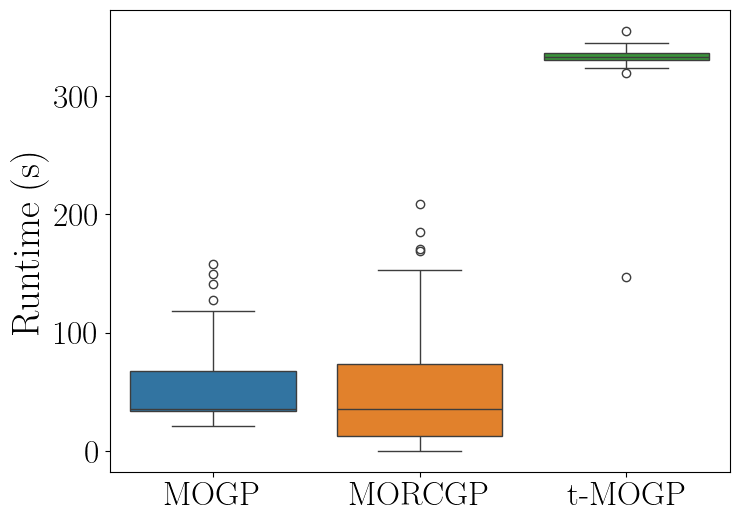

In [32]:
import seaborn as sns

# Combine lists into a list of lists
data = [mogp_all, morcgp_all, tmogp_all]

# Create violin plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data)

# Add labels
plt.xticks([0, 1, 2], ['MOGP', 'MORCGP', 't-MOGP'])
plt.ylabel('Runtime (s)')

plt.show()

In [15]:
import numpy as np

def decile_quantiles(values):
    """
    Returns the 10%, 20%, ..., 90% quantiles of a list of numbers.
    """
    probs = np.arange(0.1, 1.0, 0.1)  # 0.1, 0.2, ..., 0.9
    return np.quantile(values, probs)
# print(decile_quantiles(mogp_all))
# print(decile_quantiles(morcgp_all))
print(decile_quantiles(tmogp_all))

[326.47248 329.63544 330.83816 331.7964  333.089   334.42854 336.17286
 337.44748 339.21608]


In [30]:
def boxplot_values(values):
    probs = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
    minimum = np.min(values)
    maximum = np.max(values)
    arr = [minimum] + list(np.quantile(values, probs)) + [maximum]
    return [f"{x:.6f}" for x in arr]
# print(boxplot_values(mogp_all))
print(boxplot_values(morcgp_all))
print(boxplot_values(tmogp_all))

['0.134500', '0.145125', '12.439775', '35.712600', '73.140900', '154.022775', '209.051500']
['147.159400', '325.174505', '330.232475', '333.089000', '336.845575', '341.085615', '355.352800']
